In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import sys
sys.path.append('/root/share/personal/other/odGAN')

In [3]:
from itertools import product
import numpy as np
import pandas as pd
from resources.etl import read_etl6_data, data2array
from resources.models import DCGAN

Using TensorFlow backend.


### Auxiliary functions

In [4]:
def plot_images(images, filename=None, cols=4, figsize=(10, 10)):
    
    rows = np.ceil(len(images)/cols)
    plt.figure(figsize=figsize)
    
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        plt.imshow(np.squeeze(image), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename)
        plt.close('all')
    else:
        plt.show()

def series_to_string(series):
    string = series.to_string().split('\n')
    string = [': '.join(s.split()) for s in string]
    string = '    '.join(string)
    return string

### Build DCGAN model

#### DCGAN parameters

In [5]:
input_dim = 100

In [6]:
dcgan = DCGAN(g_input_dim=input_dim)
dcgan.build()
dcgan.summary()

Generator model:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_1 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_1 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 256)       0   

### Train DCGAN

#### Read training data

In [16]:
data = read_etl6_data('/root/share/personal/data/ETL/ETL6/')
x_all, y_all = data2array(data, new_shape=(28, 28), norm_factor=255.0, expand_dims=True)

katakana = [''.join(e) for e in product(' KSTNHMYRW', 'AIUEO')] + [' N']  # Includes obsolete characters
katakana_idx = [i for i, label in enumerate(y_all) if label in katakana]
x_train = x_all[katakana_idx]

#### Fixed noise vectors to check generator

In [19]:
check_samples = 16
noise_samples = np.random.uniform(low=-1.0, high=1.0, size=(check_samples, input_dim))

#### (optional) Pre-train adversarial discriminator

In [9]:
dcgan.pretrain(x_test, batch_size=256, epochs=1)

Epoch 1/1
20000/20000 [==============================] - 10s - loss: 0.1814 - acc: 0.9399     

#### Main training loop

In [24]:
steps = 10000
batch_size = 256

In [25]:
df = pd.DataFrame(columns=['ad_loss', 'ad_acc', 'stacked_loss', 'stacked_acc'])

for step in range(steps):
    idx = np.random.randint(0, x_train.shape[0], size=batch_size)
    ad_metrics, stacked_metrics = dcgan.train_on_batch(x_train[idx], freeze_discriminator=False)
    
    df.loc[step, ['ad_loss', 'ad_acc']] = ad_metrics
    df.loc[step, ['stacked_loss', 'stacked_acc']] = stacked_metrics
    string = df.loc[step].to_string().replace('    ',':').replace('\n', '    ')
    
    if step % 500 == 0:
        print step, series_to_string(df.loc[step])
        filename = 'fake_images_%s.png' % str(step).zfill(6)
        generated_images = dcgan.generate(noise_samples)
        plot_images(generated_images, filename)

0 ad_loss: 0.704167    ad_acc: 0.474609    stacked_loss: 0.722429    stacked_acc: 0.382812
500 ad_loss: 0.694079    ad_acc: 0.511719    stacked_loss: 0.7036    stacked_acc: 0.5
1000 ad_loss: 0.713822    ad_acc: 0.482422    stacked_loss: 0.856571    stacked_acc: 0.113281
1500 ad_loss: 0.701404    ad_acc: 0.511719    stacked_loss: 0.739793    stacked_acc: 0.324219
2000 ad_loss: 0.720273    ad_acc: 0.490234    stacked_loss: 0.874395    stacked_acc: 0.0820312
2500 ad_loss: 0.712241    ad_acc: 0.515625    stacked_loss: 0.821144    stacked_acc: 0.152344
3000 ad_loss: 0.701103    ad_acc: 0.515625    stacked_loss: 0.831921    stacked_acc: 0.136719
3500 ad_loss: 0.701374    ad_acc: 0.5    stacked_loss: 0.799067    stacked_acc: 0.210938
4000 ad_loss: 0.705581    ad_acc: 0.46875    stacked_loss: 0.768422    stacked_acc: 0.238281
4500 ad_loss: 0.699201    ad_acc: 0.511719    stacked_loss: 0.817277    stacked_acc: 0.117188
5000 ad_loss: 0.705672    ad_acc: 0.486328    stacked_loss: 0.759734    stac

In [26]:
generated_images = dcgan.generate(16)

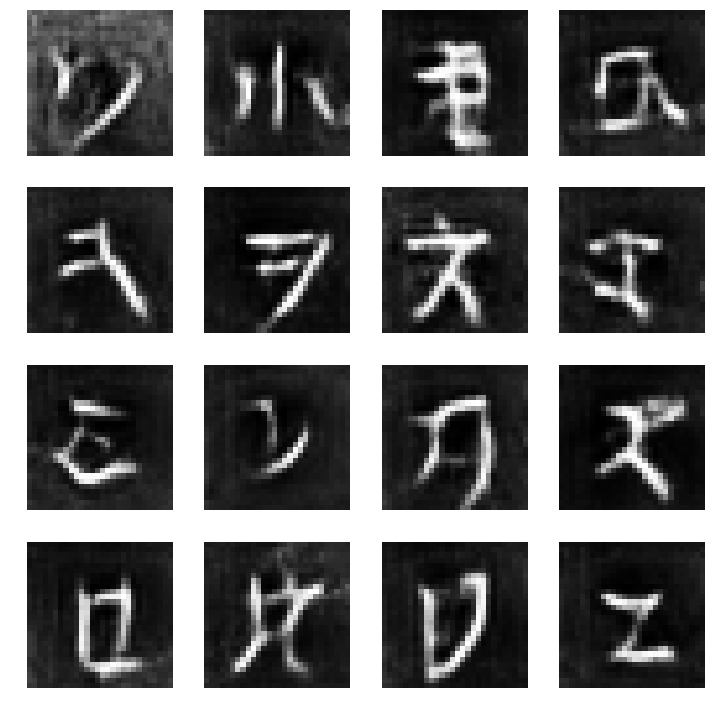

In [27]:
plot_images(generated_images)

In [16]:
print(dcgan.discriminate(generated_images))

[[ 0.50227141]
 [ 0.53848881]
 [ 0.55815732]
 [ 0.53795379]
 [ 0.48581532]
 [ 0.52256471]
 [ 0.50262952]
 [ 0.53034991]
 [ 0.51467466]
 [ 0.52781963]
 [ 0.44760016]
 [ 0.50669909]
 [ 0.55134958]
 [ 0.53114998]
 [ 0.54577178]
 [ 0.53108472]]


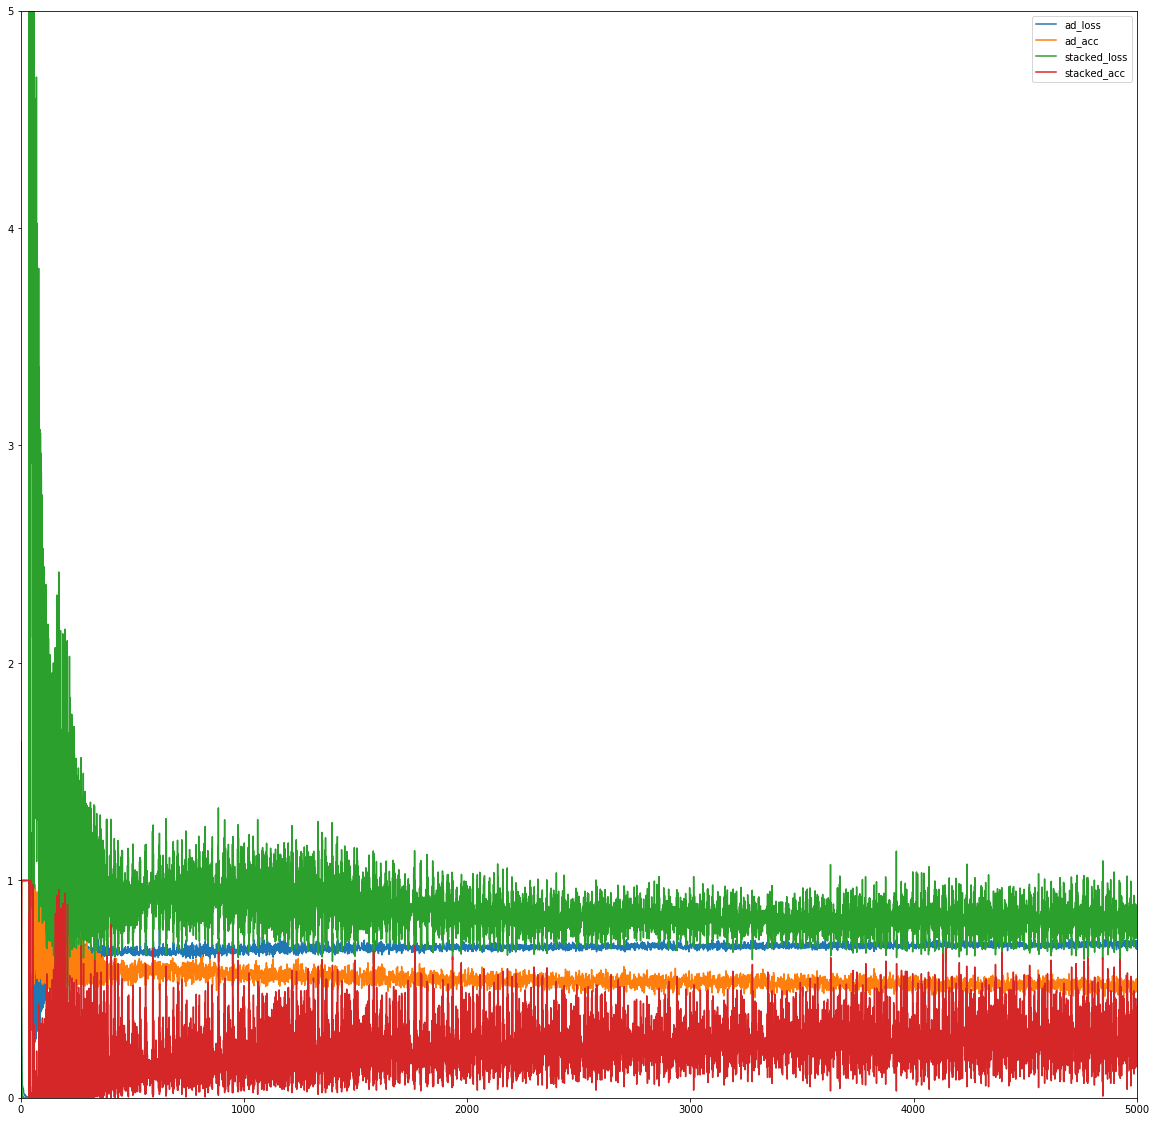

In [17]:
df.plot(figsize=(20, 20))
plt.ylim([0, 5])
plt.show()